In [6]:
%pip install -qqq python-dotenv
%pip install -qqq open_clip_torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import os
import glob

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image

from transformers import (
    CLIPModel, CLIPProcessor, 
    VisionTextDualEncoderModel, VisionTextDualEncoderProcessor,
    AutoTokenizer, AutoImageProcessor
)
from src import parse_urls_to_images, parse_ids_to_images, parse_query_to_ids, gen_figure

## First, GET our IMAGES by QUERY

We have a list of queries. For each query, do:

- get 30*k (default k=3) image ids by querying `api.unsplash.com`
- load images to a list from these image ids 
- store k-v pair {query: images} into our search cache

In [15]:
def run_search(model, processor, texts, images):
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.logits_per_text.softmax(dim=1).argsort(descending=True)

In [3]:
text = ['a cat and a dog', 'a table topped with different kinds of food', 'a person holding sand in hands']
search = {query: parse_ids_to_images(parse_query_to_ids(query, k=3)) for query in text}

In [16]:
# Load the open CLIP model
# device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cpu()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [33]:
image_processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)
model = VisionTextDualEncoderModel.from_pretrained("fangxiaoloong/clip-roberta-finetuned").cpu()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

CPU times: total: 1min 58s
Wall time: 13 s


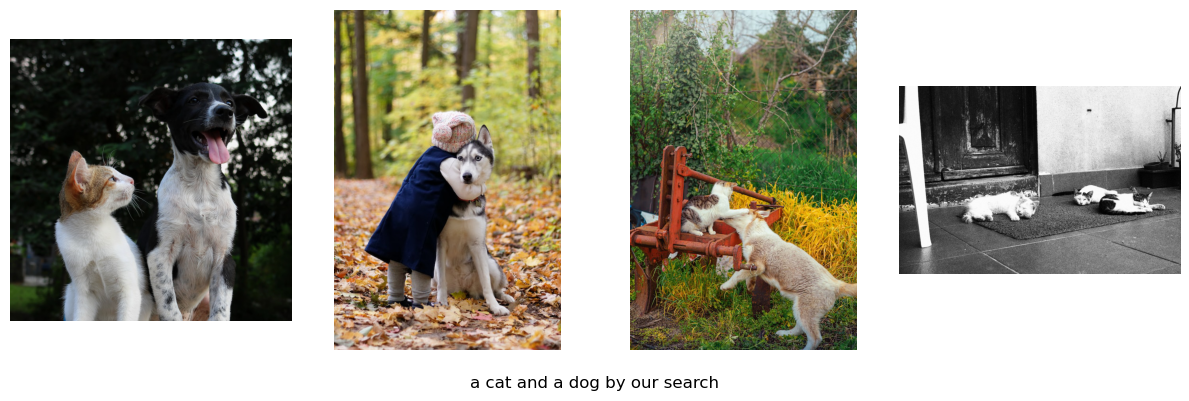

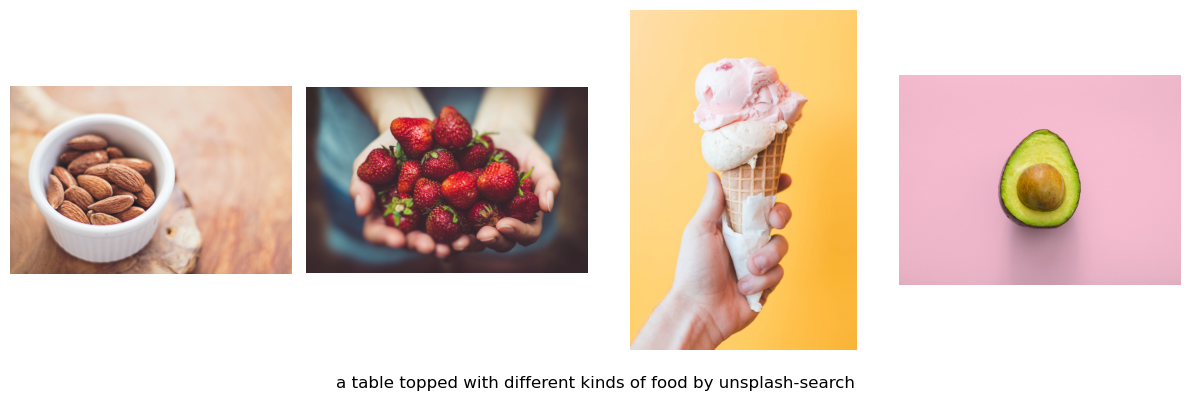

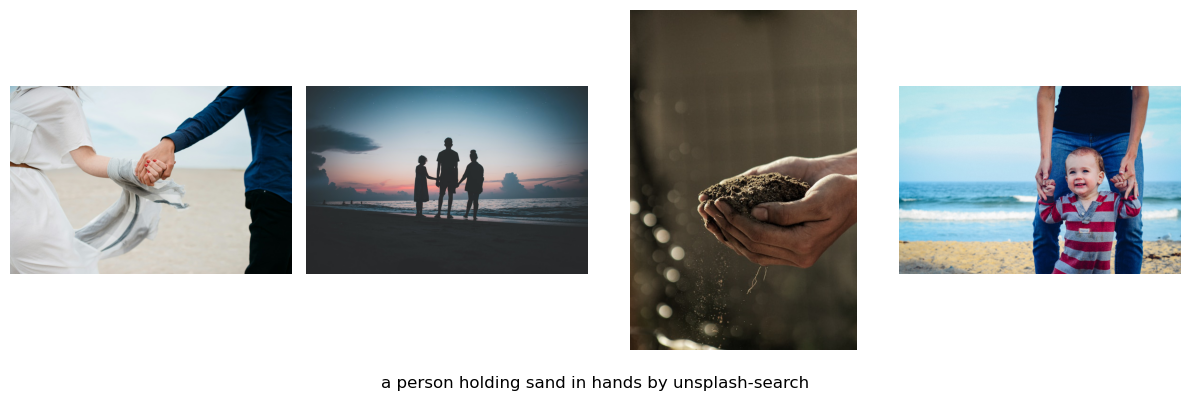

In [17]:
%%time

for query, images in search.items():
    reordering = run_search(model, processor, query, images).numpy().squeeze()
    clip_order = list(map(images.__getitem__, reordering))
    gen_figure(images, title=f"{query} by unsplash-search")
    gen_figure(clip_order, title=f"{query} by our search")
    # fig.show()

In [5]:
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('xlm-roberta-base-ViT-B-32')
tokenizer = open_clip.get_tokenizer('xlm-roberta-base-ViT-B-32')

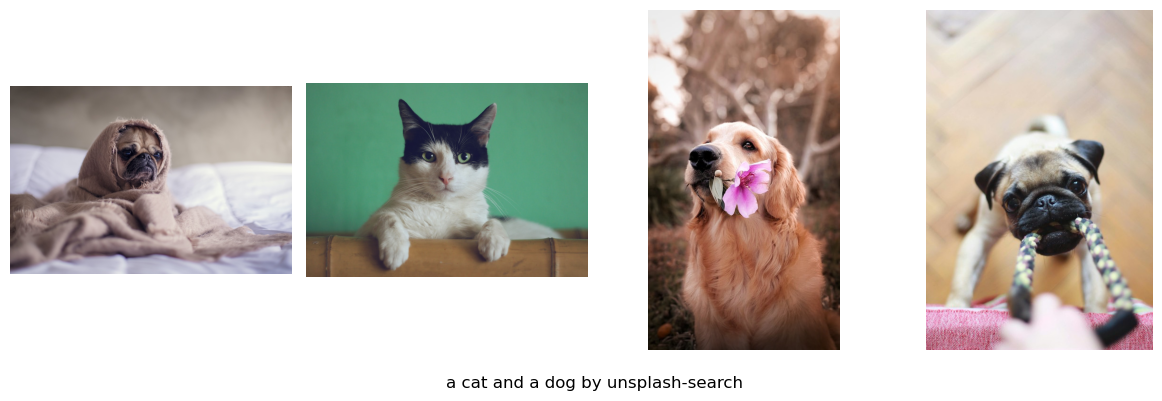

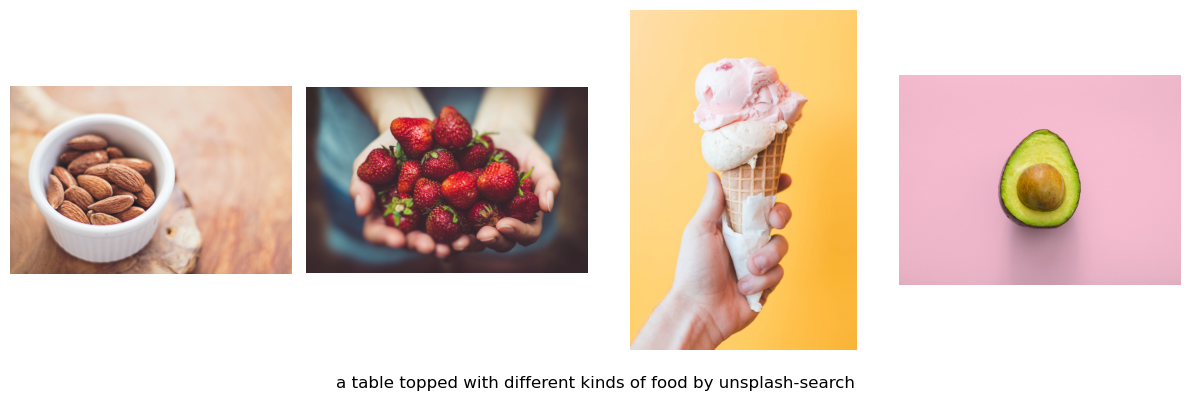

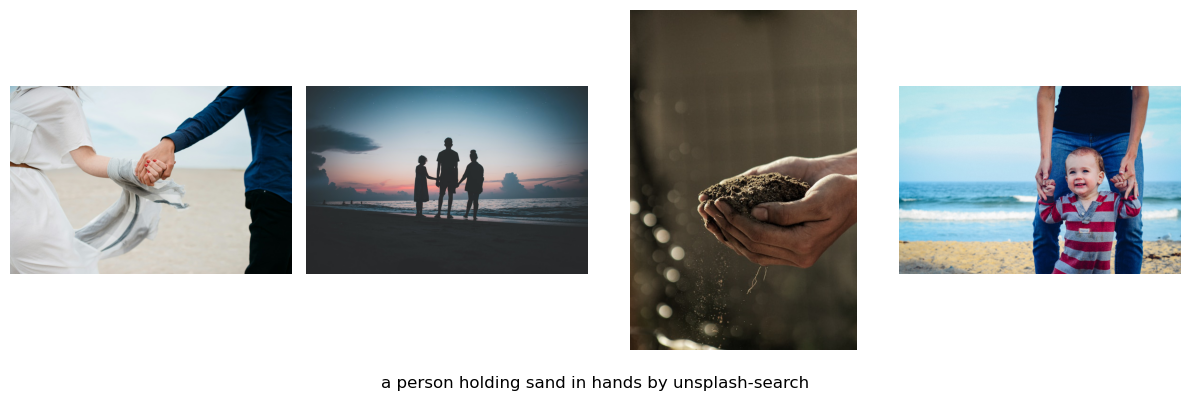

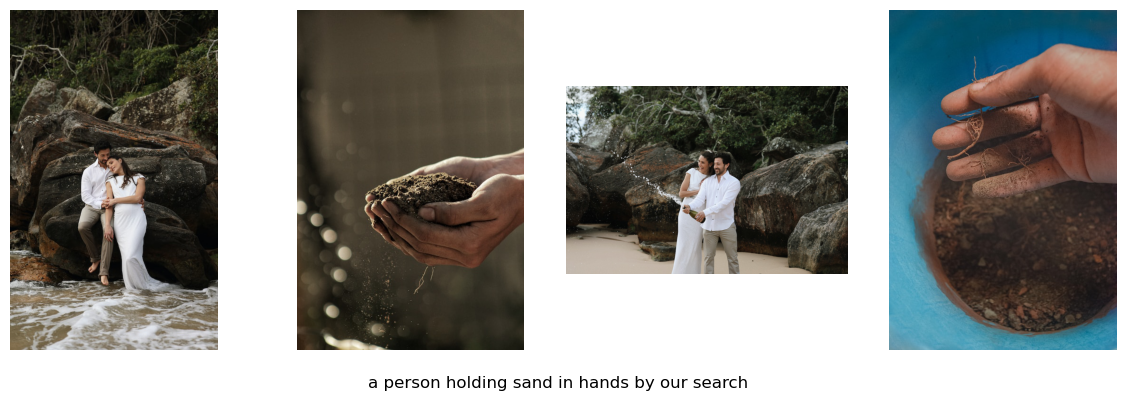

In [14]:
%%time

for query, images in search.items():
    sim = []
    text = tokenizer(query)
    for img in images:
        image = preprocess(img).unsqueeze(0)

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            probs = (image_features @ text_features.T).squeeze()
            sim.append(probs)
    sim = np.array(sim)
    reordering = (-sim).argsort()
    
    clip_order = list(map(images.__getitem__, reordering))
    gen_figure(images, title=f"{query} by unsplash-search")
    gen_figure(clip_order, title=f"{query} by our search")

In [4]:
# urls = ["http://images.cocodataset.org/val2017/000000039769.jpg", "https://unsplash.com/photos/4mA9_5vbZ_s/download?force=true&w=360"]
# images = parse_urls_to_images(urls)
# text = ["two cats", "three cats"]